In [1]:
import polars as pl
import os

import sys
sys.path.append('..')
from src import PlottingFunctions

plotter = PlottingFunctions.Plotter()
import numpy as np
import xarray as xr
import json
import matplotlib.pyplot as plt

from src import IOFunctions; IO = IOFunctions.IO_Functions()

In [2]:
dab_folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Data/dab example segmentation/Imperial_BB_DAB_Gandhilab_2025/'

In [3]:
files = os.listdir(dab_folder)
areas = np.sort([os.path.join(dab_folder, x) for x in files if 'areaanalysed' in x])
protein_objects = np.sort([os.path.join(dab_folder, x) for x in files if 'protein_stain_analysis' in x])
region_key = np.sort([os.path.join(dab_folder, x) for x in files if 'BrainRegions' in x])
region_key = pl.read_csv(region_key [0])
unique_region_labels = np.unique(region_key['Area'].to_numpy())

In [4]:
patients = np.unique([x.split('/')[-1].split('-')[0] for x in protein_objects])
regions = np.unique([x.split('/')[-1].split('-')[1].split('_')[0] for x in protein_objects])

In [5]:
region_key

Area,String
str,i64
"""Frontal""",1
"""Cingulate""",2
"""Parahippocampus""",9
"""Parahippocampus""",10
"""Parietal""",13
"""SubstantiaNigra""",15
"""Temporal""",4
"""Caudate""",5


In [6]:
lb_definition = 5

In [7]:
lb_definition = np.pi*np.square(2.5)

In [14]:
data_frame = {}
pd_ids = ['PD1101', 'PD802', 'PD822', 'PD913', 'PD917', 'PD945', 'PD976', 'PD980']
hc_ids = ['C0064', 'C0072', 'C0073', 'C0074', 'C0075', 'PDC0022', 'PDC0023', 'PDC0027', 'PDC0029', 'PDC0034', 'PDC0035', 'PDC0078', 
         'PDC0085', 'PDC0087']
data_frame['Patient'] = np.zeros(len(protein_objects), dtype='object')
data_frame['Density'] = np.full(len(protein_objects), np.nan)
data_frame['Region'] = np.zeros(len(protein_objects), dtype='object')
data_frame['Disease'] = np.zeros(len(protein_objects), dtype='object')
for i, file in enumerate(protein_objects):
    area_imaged_um2 = np.multiply(float(IO.load_json(areas[i])['area_analysed']), np.square(1e6))
    number_objects = pl.read_csv(file)
    number_objects = number_objects.filter(pl.col('area') > lb_definition)
    number_objects = number_objects.filter(pl.col('pseudo_circularity') > 0.7)
    data_frame['Density'][i] = (len(number_objects['area'].to_numpy())/area_imaged_um2)
    data_frame['Patient'][i] = file.split('/')[-1].split('-')[0]
    data_frame['Region'][i] = region_key.filter(pl.col("String") == int(file.split('/')[-1].split('-')[1].split('_')[0])).to_numpy()[:, 0][0]
    if file.split('/')[-1].split('-')[0] in pd_ids:
        data_frame['Disease'][i] = 'PD'
    else:
        data_frame['Disease'][i] = 'Control'

In [15]:
overall_data = pl.DataFrame(data=data_frame)

In [16]:
np.unique(overall_data['Region'])

array(['Caudate', 'Cingulate', 'Frontal', 'Parahippocampus', 'Parietal',
       'SubstantiaNigra', 'Temporal'], dtype='<U15')

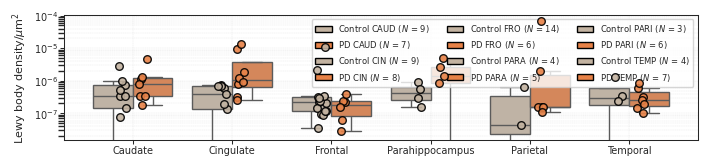

In [22]:
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
mm = 1/25.4  # centimeters in inches

fig, axs = plotter.two_column_plot(height=(170/4)*mm, width=180*mm, lw=0.75)

# Create custom palette and rename HC to Control
palette = {'PD': '#E88247', 'Control': '#C3B3A1'}
hue_order = ['Control', 'PD']  # Define explicit order
region_order = ['Caudate', 'Cingulate', 'Frontal', 'Parahippocampus', 'Parietal', 'Temporal']

axs = sns.boxplot(
        data=overall_data,
        x="Region",
        y="Density",
        hue="Disease",
        hue_order=hue_order,
        palette=palette,
        showfliers=False,  # Don't show outliers
        ax=axs,
        order=region_order
    )

axs.tick_params(labelsize=7)
axs.set_ylabel(r"Lewy body density/$\mu$m$^2$",fontsize=8)

for i, region in enumerate(region_order):
        region_data = overall_data.filter(pl.col('Region') == region)
        
        # For each disease
        for j, disease in enumerate(hue_order):
            disease_data = region_data.filter(pl.col('Disease') == disease)
            donor_medians = disease_data.group_by('Patient').agg(pl.col("Density").median())
            
            if donor_medians.shape[0] == 0:
                continue
            
            # Calculate position for this box
            num_hues = len(hue_order)
            offset = 0.4  # Total width of hue groups
            pos_offset = (j - (num_hues-1)/2) * (offset/num_hues)
            x_pos_base = i + pos_offset
            
            for k, median_val in enumerate(donor_medians["Density"].to_numpy()):
                # Add random jitter
                jitter = np.random.uniform(-0.05, 0.05)
                
                # Scatter plot for donor medians
                axs.scatter(
                    x_pos_base + jitter,
                    median_val,
                    color=palette[disease],
                    edgecolor='black',
                    s=30,
                    alpha=0.9,
                    zorder=10  # Ensure points are on top
                )

axs.set_yscale('log')
axs.grid(True, which="both", ls="--", color="gray", lw=0.25, alpha=0.25)

# Calculate stats for each region and disease combination
legend_elements = []

# Remove default legend
axs.get_legend().remove()

# Create custom legend with donor and cell counts for each region and disease
for region in region_order:
    for disease in hue_order:
        region_disease_data = overall_data.filter((pl.col('Region') == region) & (pl.col('Disease') == disease))
        if not region_disease_data.shape[0] == 0:
            unique_donors = len(np.unique(region_disease_data['Patient'].to_numpy()))
            object_count = len(region_disease_data)
            region_short = "PARI" if region == "Parietal" else "CIN" if region == "Cingulate" else "FRO" if region == "Frontal" else "PARA" if region == "Parahippocampus" else "TEMP" if region == "Temporal" else "CAUD"
            label = f"{disease} {region_short} ($\\it{{N}}$ = {unique_donors})"
            legend_elements.append(Patch(facecolor=palette[disease], edgecolor='black', label=label))

# Add the custom legend
axs.legend(handles=legend_elements, loc='upper right', fontsize=6, ncols=3)
#axs.set_ylim([4e-6, 8e-2])
axs.set(xlabel=None)
plt.tight_layout()
folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Papers/ASAP_Main/Figure_4/'
plt.savefig(os.path.join(folder, 'DAB_analysis_LB.svg'), dpi=600, format='svg')

In [18]:
donor_medians.shape

(7, 2)

In [2]:
import skimage as ski

In [2]:
folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Papers/ASAP_Main/Figure_4/Raw_DAB_images/'
caudate = np.asarray(IO.read_tiff(os.path.join(folder, 'PD913_Caudate.tiff')), dtype=np.uint8)
cingulate = np.asarray(IO.read_tiff(os.path.join(folder, 'PD913_Cingulate.tiff')), dtype=np.uint8)
frontal = np.asarray(IO.read_tiff(os.path.join(folder, 'PD913_Frontal.tiff')), dtype=np.uint8)
parietal = np.asarray(IO.read_tiff(os.path.join(folder, 'PD913_Parietal.tiff')), dtype=np.uint8)

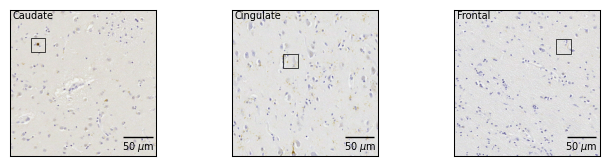

In [78]:
mm = 1/25.4  # centimeters in inches

fig, axs = plotter.two_column_plot(height=(170/4)*mm, width=180*mm, lw=0.75, ncolumns=3, widthratio=[1,1,1])
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as patches

axs[0].imshow(caudate)

scalebarlabel = r'50 $\mu$m'
pixvals = 50 / 0.25

regs = ['Caudate', 'Cingulate', 'Frontal', 'Parietal']

boxes = np.array([(190, 290, 140, 240), (300, 400, 350, 450), (200, 300, 700, 800), (750, 850, 150, 250)])



axs[1].imshow(cingulate)

axs[2].imshow(frontal)

for i in np.arange(3):
    scalebar = AnchoredSizeBar(
    axs[i].transData,
    pixvals,
    scalebarlabel,
    "lower right",
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1,
    )
    axs[i].add_artist(scalebar)
    axs[i].annotate(
    regs[i],
    xy=(5, 5),
    xytext=(20, 60),
    xycoords="data",
    color="black",
    fontsize=8 - 1,
    )
    height = boxes[i][1] - boxes[i][0]
    width = boxes[i][-1] - boxes[i][-2]
    rect = patches.Rectangle((boxes[i][2], boxes[i][0]), height, width, linewidth=0.5, edgecolor='black', facecolor='none')
    axs[i].add_patch(rect)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()

folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Papers/ASAP_Main/Figure_4/'
plt.savefig(os.path.join(folder, 'DAB_analysis_Images.svg'), dpi=600, format='svg')

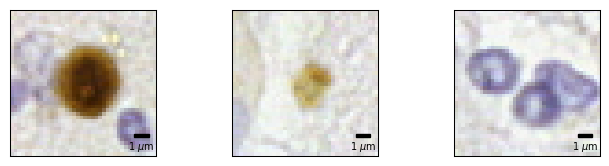

In [50]:
mm = 1/25.4  # centimeters in inches

fig, axs = plotter.two_column_plot(height=(170/4)*mm, width=180*mm, lw=0.75, ncolumns=3, widthratio=[1,1,1])
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

x1 = 220
diff = 40
y1 = 169
axs[0].imshow(caudate[x1:x1+diff, y1:y1+diff])

scalebarlabel = r'1 $\mu$m'
pixvals = 1 / 0.25

regs = ['Caudate', 'Cingulate', 'Frontal', 'Parietal']


x1 = 341
y1 = 355
axs[1].imshow(cingulate[x1:x1+diff, y1:y1+diff])

x1 = 260
y1 = 782
axs[2].imshow(frontal[x1:x1+diff, y1:y1+diff])


for i in np.arange(3):
    scalebar = AnchoredSizeBar(
    axs[i].transData,
    pixvals,
    scalebarlabel,
    "lower right",
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1,
    )
    axs[i].add_artist(scalebar)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()

folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Papers/ASAP_Main/Figure_4/'
plt.savefig(os.path.join(folder, 'DAB_analysis_Images_zoom.svg'), dpi=600, format='svg')

In [ ]:
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
mm = 1/25.4  # centimeters in inches

fig, axs = plotter.two_column_plot(height=(170/4)*mm, width=180*mm, lw=0.75)

# Create custom palette and rename HC to Control
palette = {'PD': '#E88247', 'Control': '#C3B3A1'}
hue_order = ['Control', 'PD']  # Define explicit order
region_order = ['Caudate', 'Cingulate', 'Frontal', 'Parietal']

axs = sns.boxplot(
        data=overall_data,
        x="Region",
        y="Density",
        hue="Disease",
        hue_order=hue_order,
        palette=palette,
        showfliers=False,  # Don't show outliers
        ax=axs,
        order=region_order
    )

axs.tick_params(labelsize=7)
axs.set_ylabel(r"Lewy Body density",fontsize=8)

for i, region in enumerate(region_order):
        region_data = overall_data.filter(pl.col('Region') == region)
        
        # For each disease
        for j, disease in enumerate(hue_order):
            disease_data = region_data.filter(pl.col('Disease') == disease)
            donor_medians = disease_data.group_by('Patient').agg(pl.col("Density").median())
            
            if donor_medians.shape[0] == 0:
                continue
            
            # Calculate position for this box
            num_hues = len(hue_order)
            offset = 0.4  # Total width of hue groups
            pos_offset = (j - (num_hues-1)/2) * (offset/num_hues)
            x_pos_base = i + pos_offset
            
            for k, median_val in enumerate(donor_medians["Density"].to_numpy()):
                # Add random jitter
                jitter = np.random.uniform(-0.05, 0.05)
                
                # Scatter plot for donor medians
                axs.scatter(
                    x_pos_base + jitter,
                    median_val,
                    color=palette[disease],
                    edgecolor='black',
                    s=30,
                    alpha=0.9,
                    zorder=10  # Ensure points are on top
                )

axs.set_yscale('log')
axs.grid(True, which="both", ls="--", color="gray", lw=0.25, alpha=0.25)

# Calculate stats for each region and disease combination
legend_elements = []

# Remove default legend
axs.get_legend().remove()

# Create custom legend with donor and cell counts for each region and disease
for region in region_order:
    for disease in hue_order:
        region_disease_data = overall_data.filter((pl.col('Region') == region) & (pl.col('Disease') == disease))
        if not region_disease_data.shape[0] == 0:
            unique_donors = len(np.unique(region_disease_data['Patient'].to_numpy()))
            object_count = len(region_disease_data)
            region_short = "PARI" if region == "Parietal" else "CIN" if region == "Cingulate" else "FRO" if region == "Frontal" else "PARA" if region == "Parahippocampus" else "TEMP" if region == "Temporal" else "CAUD"
            label = f"{disease} {region_short} ($\\it{{N}}$ = {unique_donors})"
            legend_elements.append(Patch(facecolor=palette[disease], edgecolor='black', label=label))

# Add the custom legend
axs.legend(handles=legend_elements, loc='upper right', fontsize=6, ncols=1, bbox_to_anchor=(1.26, 1.05))
axs.set_ylim([4e-6, 8e-2])
axs.set(xlabel=None)
plt.tight_layout()
folder = '/home/jbeckwith/Documents/Cambridge University Dropbox/Joseph Beckwith/Chemistry/Lee/Papers/ASAP_Main/Figure_4/'
plt.savefig(os.path.join(folder, 'DAB_analysis_LB.svg'), dpi=600, format='svg')